In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


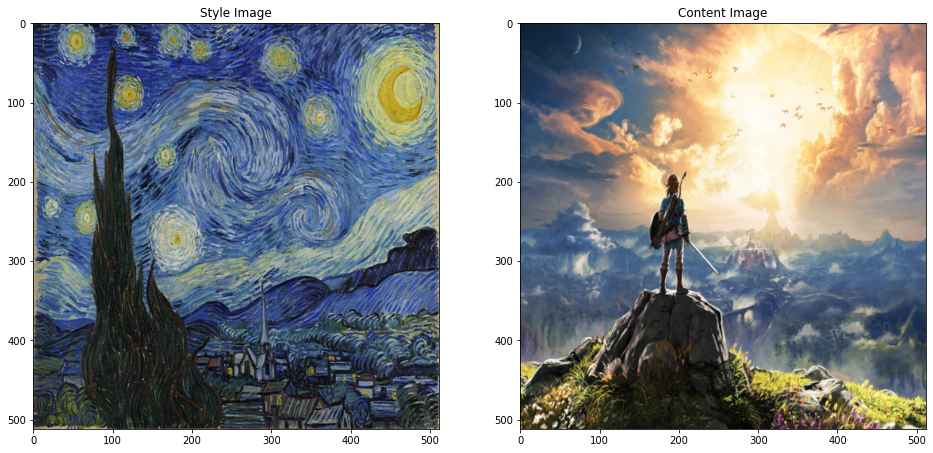

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np 
import random
import time 
import os

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
imsize = 512 

loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])


style_img = image_loader("/gdrive/MyDrive/NeuralStyleTransfer/starrynight.jpg")
content_img = image_loader("/gdrive/MyDrive/NeuralStyleTransfer/zelda-landscape.jpg")
unloader = transforms.ToPILImage()  



plt.figure(figsize=(16, 12))
ax = plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')
plt.show()

# VGG-11

In [4]:
cnn = models.vgg11(pretrained=True).features.to(device)

for layer in cnn:
    if isinstance(layer, nn.ReLU):
      layer.inplace = False

for name, param in cnn.named_parameters():
    param.requires_grad = False


style_conv1 = cnn[0]
style_conv2 = cnn[1:4]
style_conv3 = cnn[4:7]
style_conv4 = cnn[7:9]
style_conv5 = cnn[9:12]
style_convlist = [style_conv1, style_conv2, style_conv3, style_conv4, style_conv5]


content_conv = cnn[0:9]


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


# necessary function

In [5]:
def mse_loss(input, target):
    result = ((input-target)**2).sum()
    temp = input.reshape(1,-1)
    result = result/temp.shape[1]
    return result

def gram_matrix(feature_map):
    channel_num = feature_map.shape[1] 
    gram_feature_map = torch.reshape(feature_map, (channel_num, -1))
    gram_feature_map_T = torch.transpose(gram_feature_map, 0, 1)
    return torch.matmul(gram_feature_map, gram_feature_map_T)

def compute_content_loss(input, target, content_conv):
    input_feature_map = content_conv[0](input)
    target_feature_map = content_conv[0](target)
    for i in range(1, len(content_conv)):
        input_feature_map = content_conv[i](input_feature_map)
        target_feature_map = content_conv[i](target_feature_map)
    return mse_loss(input_feature_map, target_feature_map)

def compute_style_loss(input, target, style_convlist):
    input_feature_map = style_convlist[0](input)
    target_feature_map = style_convlist[0](target)

    input_gram_map = gram_matrix(input_feature_map)
    target_gram_map = gram_matrix(target_feature_map)

    style_loss = mse_loss(input_gram_map, target_gram_map)

    for i in range(1, len(style_convlist)):
        for j in range(len(style_convlist[i])):
            input_feature_map = style_convlist[i][j](input_feature_map)
            target_feature_map = style_convlist[i][j](target_feature_map)

        input_gram_map = gram_matrix(input_feature_map)
        target_gram_map = gram_matrix(target_feature_map)

        style_loss += mse_loss(input_gram_map, target_gram_map)
        
    return style_loss / len(style_convlist)


# Learning

In [8]:
input_img = content_img.clone()
optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)

style_weight = 10000       
content_weight = 10          
iteration = 5000    

for i in range(iteration):
    content_loss = compute_content_loss(input_img, content_img, content_conv)    
    style_loss = compute_style_loss(input_img, style_img, style_convlist)      
    loss = content_weight * content_loss + style_weight * style_loss     

    optimizer.zero_grad()                                                      
    loss.backward()                                                            
    optimizer.step()                                                             
    
    if i % 1000 == 0:
        print("iteration {}:".format(i))
        print('Style Loss : {:2f} Content Loss: {:2f}'.format((style_weight * style_loss).item(), (content_weight * content_loss).item()))

iteration 0:
Style Loss : 5887000838144.000000 Content Loss: 0.000000
iteration 1000:
Style Loss : 1038567104.000000 Content Loss: 37.863499
iteration 2000:
Style Loss : 38549860352.000000 Content Loss: 38.429398
iteration 3000:
Style Loss : 165837232.000000 Content Loss: 42.304779
iteration 4000:
Style Loss : 685340096.000000 Content Loss: 42.964333


# Output

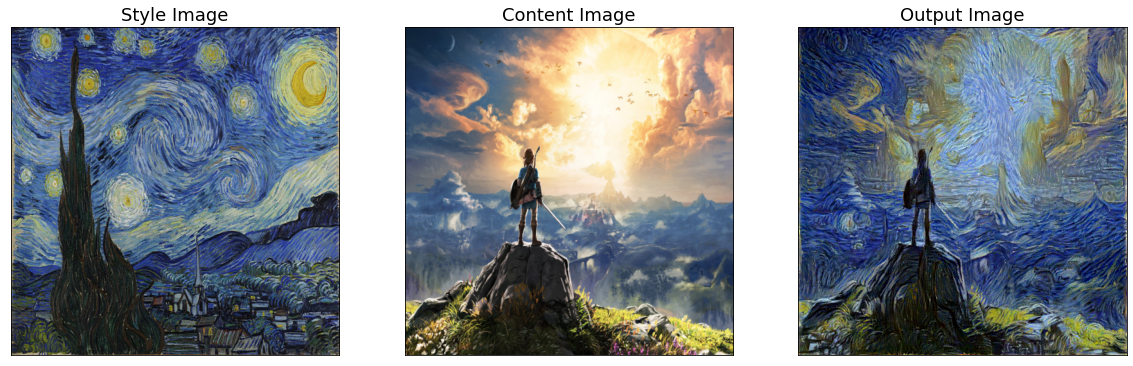

In [17]:
input_img.data.clamp_(0, 1)
plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1)
plt.xticks([]); plt.yticks([])
plt.title('Style Image', fontsize=18)
imshow(style_img)
plt.subplot(1, 3, 2)
plt.xticks([]); plt.yticks([])
plt.title('Content Image', fontsize=18)
imshow(content_img)
plt.subplot(1, 3, 3)
plt.xticks([]); plt.yticks([])
plt.title('Output Image', fontsize=18)
imshow(input_img)
plt.show()